In [1]:
# --- Step 1: Import Libraries ---
import os, time, random
import numpy as np
import cv2
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
# --- Step 2: Config ---
DATA_ROOT = "CCSN_v2"
IMG_HEIGHT, IMG_WIDTH = 128, 128
PCA_COMPONENTS = 12
RANDOM_SEED = 42

In [3]:
# --- Step 3: Load Dataset ---
class_names = sorted([f for f in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, f))])

images, labels = [], []
for dir_name in tqdm(class_names, desc="Loading class folders"):
    class_path = os.path.join(DATA_ROOT, dir_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith('.jpg'):
            img = cv2.imread(os.path.join(class_path, fname))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(dir_name)

labels = np.array(labels)
print(f"Loaded {len(images)} images across {len(class_names)} classes.")


Loading class folders: 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

Loaded 2543 images across 11 classes.


In [4]:
# --- Step 4: Preprocessing & Augmentation ---
class ImagePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, height=128, width=128):
        self.height = height
        self.width = width

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        resized = [cv2.resize(img, (self.width, self.height), interpolation=cv2.INTER_CUBIC) for img in X]
        return np.array(resized)
    
    def augment(self, X, y):
        aug_images, aug_labels = [], []
        center = (self.width // 2, self.height // 2)
        for i, img in enumerate(tqdm(X, desc="Augmenting data")):
            aug_images.append(img); aug_labels.append(y[i])
            for angle in [90, 180, 270]:
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                aug_images.append(cv2.warpAffine(img, M, (self.width, self.height)))
                aug_labels.append(y[i])
        return np.array(aug_images), np.array(aug_labels)

# Apply preprocessing
pre = ImagePreprocessor(IMG_HEIGHT, IMG_WIDTH)
resized = pre.transform(images)
augmented, labels_aug = pre.augment(resized, labels)
print(f"Dataset after augmentation: {len(augmented)} images")

# Grayscale + Flatten
X = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).flatten() for img in tqdm(augmented, desc="Grayscaling & Flattening")])

# Encode labels
class_to_idx = {name: i for i, name in enumerate(class_names)}
y = np.array([class_to_idx[label] for label in labels_aug])


Augmenting data: 100%|██████████| 2543/2543 [00:00<00:00, 2750.32it/s]


Dataset after augmentation: 10172 images


Grayscaling & Flattening: 100%|██████████| 10172/10172 [00:00<00:00, 61734.85it/s]


In [5]:
# --- Step 5: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 8137, Test samples: 2035


In [6]:
# --- Step 6: Scaling & PCA ---
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_SEED)
X_train_pca, X_test_pca = pca.fit_transform(X_train_scaled), pca.transform(X_test_scaled)


In [7]:
# --- Step 7: Model Benchmarking ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1),
}

results = {}
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    acc = model.score(X_test_pca, y_test)
    results[name] = acc
    print(f"{name}: {acc*100:.2f}%")

best_model_name = max(results, key=results.get)
print(f"\nBest baseline model: {best_model_name} ({results[best_model_name]*100:.2f}%)")


Logistic Regression: 18.57%
Random Forest: 43.00%
Extra Trees: 52.58%

Best baseline model: Extra Trees (52.58%)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, ma

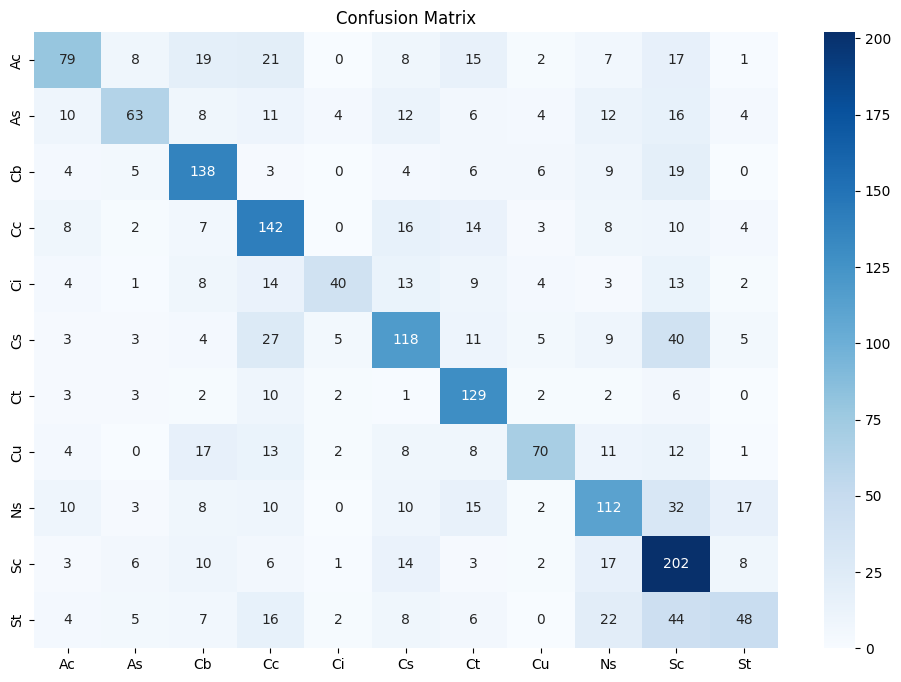

In [8]:
# --- Step 8: Hyperparameter Tuning (Extra Trees as example) ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}
search = RandomizedSearchCV(ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1),
                            param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=RANDOM_SEED)
search.fit(X_train_pca, y_train)

final_model = search.best_estimator_
y_pred = final_model.predict(X_test_pca)
print("\nBest Params:", search.best_params_)
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# --- Step 9: Retrain on Full Dataset ---
X_full_pca = np.vstack([X_train_pca, X_test_pca])
y_full = np.concatenate([y_train, y_test])

production_model = ExtraTreesClassifier(**search.best_params_, random_state=RANDOM_SEED, n_jobs=-1)
production_model.fit(X_full_pca, y_full)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [10]:
# --- Step 10: Save Final Artifacts ---
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(pca, 'pca.joblib')
joblib.dump(production_model, 'cloud_model.joblib')
print("💾 Saved scaler, PCA, and final model.")

💾 Saved scaler, PCA, and final model.
